In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import os
os.chdir("../../")
from ReusableCode.bv_vis import biasVarianceCompFrame, plotBV
os.chdir("./MedicalInsuranceCost/notebook/")

import warnings

# Load Data and EDA

In [14]:
df = pd.read_csv('.././data/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Column sex has 2 unique values


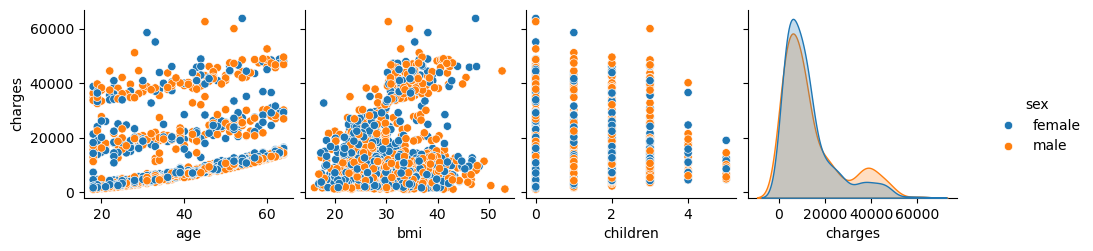

Column smoker has 2 unique values


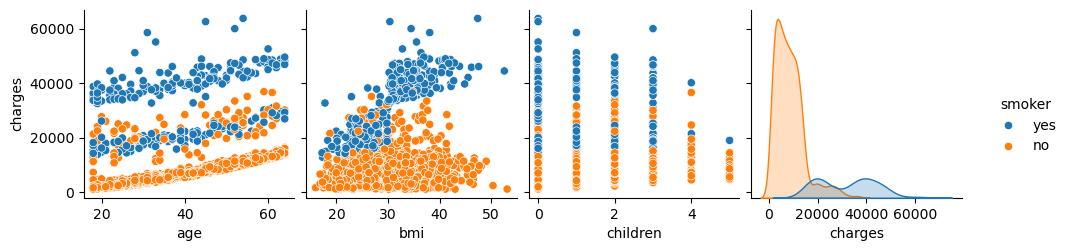

Column region has 4 unique values


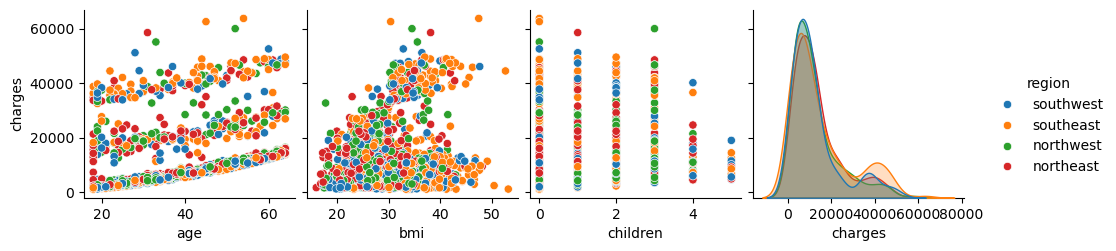

In [15]:
warnings.filterwarnings("ignore")
is_cat_column, is_num_column = [],[]
for c in df.columns:
    if df[c].dtype==object:
        print(f'Column {c} has {len(df[c].unique())} unique values')
        sns.pairplot(data = df, y_vars = 'charges',hue = c)
        plt.show()
        is_cat_column.append(c)
    else:
        is_num_column.append(c)

## Correllation Matrix

               age       bmi  children   charges
age       1.000000  0.109272  0.042469  0.299008
bmi       0.109272  1.000000  0.012759  0.198341
children  0.042469  0.012759  1.000000  0.067998
charges   0.299008  0.198341  0.067998  1.000000


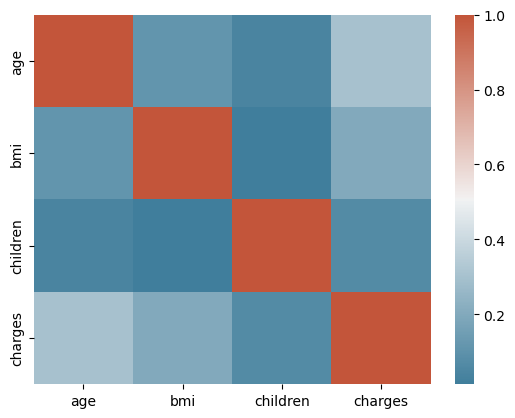

In [16]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df[is_num_column].corr(), cmap = cmap)

print(df[is_num_column].corr())

This is a pretty weak correlation matrix. The strongest predictor of ```charges``` is ```age``` but it is only $\approx .3$.

## Looking at BMI

Looking at the plot above, the ```bmi``` variable seems to have a sharp change at the value of 30.

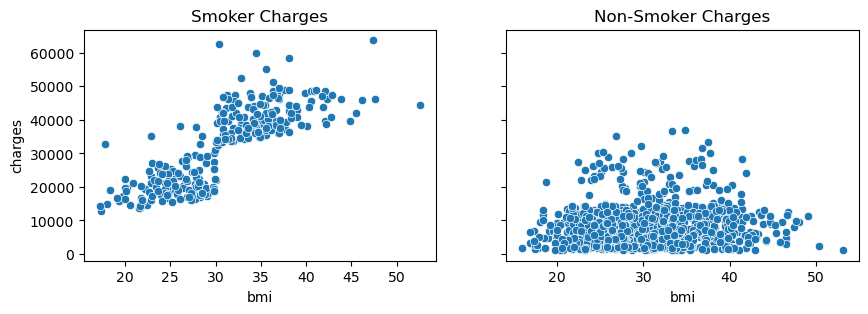

In [17]:
fig, ax = plt.subplots(1,2,figsize = (10,3),sharey = True)
sns.scatterplot(data = df[df.smoker=='yes'],x = 'bmi',y='charges',ax = ax[0])
sns.scatterplot(data = df[df.smoker=='no'],x = 'bmi',y='charges',ax = ax[1])
ax[0].set_title('Smoker Charges')
ax[1].set_title( 'Non-Smoker Charges')

plt.show()

Later, we will add another feature that captures this change.

# Analysis

## Split Data

In [18]:
## Manually create dummy variables
df = pd.read_csv('../data/insurance.csv')
df.sex = df.sex.apply(lambda x: 1*(x=='male'))
df.smoker = df.smoker.apply(lambda x: 1*(x=='yes'))
df['north_east'] = df.region.apply(lambda x: 1*(x =='northeast'))
df['north_west'] = df.region.apply(lambda x: 1*(x =='northwest'))
df['south_west'] = df.region.apply(lambda x: 1*(x =='southwest'))
df.drop(columns = ['region'],inplace = True)


## Reorder columns
cols = list(df.columns)
cols.append(cols.pop(5))
df = df[cols]
df.head()

## TrainTestSplit
from sklearn.model_selection import train_test_split
random_state = 42
df_train, df_test = train_test_split(df, test_size = .2, shuffle = True, random_state=random_state)
X_train = df_train[cols[:-1]].to_numpy()
X_test = df_test[cols[:-1]].to_numpy()
y_train = df_train[cols[-1]].to_numpy()
y_test = df_test[cols[-1]].to_numpy()

## Grid

from sklearn.model_selection import RepeatedKFold,GridSearchCV

n_repeats = 3
n_folds = 10
cv_trials = n_repeats*n_folds
cv = RepeatedKFold(n_repeats = n_repeats, n_splits = n_folds)

## Base Model (Linear Regression)

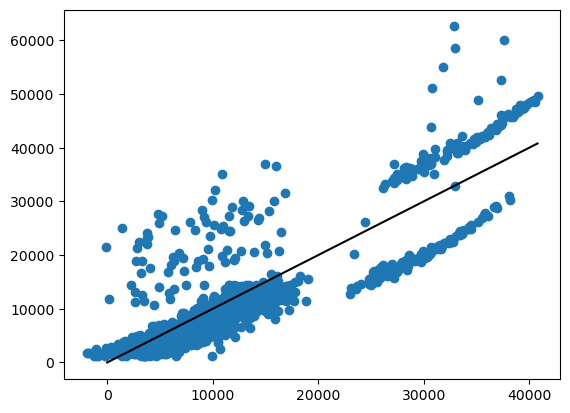

Base R2 is 0.742
Base RMSE is 6105.545


In [19]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)
y_pred = lm.predict(X_train)
plt.scatter(y_pred,y_train)

plt.plot([0,max(y_pred)],[0,max(y_pred)],color = 'k')
plt.show()

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

RMSE = lambda x,y: MSE(x,y)**(1/2)

base_RMSE = RMSE(y_pred,y_train)
train_var = np.var(y_train)

base_r2 = r2_score(y_train,y_pred)
print(f"Base R2 is {base_r2:.3f}")
print(f"Base RMSE is {base_RMSE:.3f}")

## Load All Models

In [20]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

## Polynomial Features
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer

## Pipeline
from sklearn.pipeline import Pipeline

In [21]:
# Standard Estimators
simple_estimators = {
    'lin_reg':LinearRegression(),
    'ridge':Ridge(),
    'lasso':Lasso(),
    'knn':KNeighborsRegressor(),
    'tree':DecisionTreeRegressor(random_state=random_state),
    'rf':RandomForestRegressor(random_state = random_state),
    'gb_reg':GradientBoostingRegressor(random_state=random_state)
}

# Pipelines

## PolynomialTransformer
poly_features = [0,2,3]
pass_features = [j for j in range(X_train.shape[1]) if j not in poly_features]
poly = ColumnTransformer(
    transformers = [
        ('poly',PolynomialFeatures(include_bias=False),poly_features),
        ('pass','passthrough',pass_features)
    ]
)


pipelines = {
    'lin_reg_pipe':
        Pipeline(
            [
                ('pre', poly),
                ('model',LinearRegression())
            ]
        ),
    'lasso_pipe':
        Pipeline(
            [
                ('pre', poly),
                ('model',Lasso())
            ]
        ),
    'ridge_pipe':
        Pipeline(
            [
                ('pre', poly),
                ('model',Ridge())
            ]
        )
    
}

# Metrics
metrics = ['neg_root_mean_squared_error','neg_mean_absolute_error']


# Parameter Grids
max_degree = 7

poly_grid = {'pre__poly__degree':list(range(1,max_degree+1))}

regularization_range = [0.1,.2,.5,1,2,5,10]
ridge_lasso_params = {'alpha':regularization_range}
ridge_lasso_params_poly = {'model__alpha':regularization_range}
dt_params = {
    'splitter':['random','best'],
    'max_depth':list(range(2,21))
}

K_max = 10
knn_params = {
    'n_neighbors':list(range(1,K_max+1)),
    'weights':['uniform','distance']
}

max_depth = 7
min_depth = 2
rf_params = {
    'max_depth':list(range(min_depth,max_depth+1)),
    'n_estimators':[25,50,75,100]
}

gb_params = {
    'max_depth':list(range(min_depth,max_depth+1)),
    'n_estimators':[25,50,75,100]
}

param_grids = {
    'lin_reg':{},
    'ridge':ridge_lasso_params,
    'lasso':ridge_lasso_params,
    'knn':knn_params,
    'tree':dt_params,
    'rf':rf_params,
    'gb_reg':gb_params,
    'lin_reg_pipe':poly_grid,
    'lasso_pipe':poly_grid|ridge_lasso_params_poly,
    'ridge_pipe':poly_grid|ridge_lasso_params_poly    
}

# Rename Parameters

param_renames = {
    'ridge':{'Regularization Parameter':'param_alpha'},
    'lasso':{'Regularization Parameter':'param_alpha'},
    'knn':{'Neighbors':'param_n_neighbors','Weight':'param_weights'},
    'tree':{'Depth':'param_max_depth','Splitter':'param_splitter'},
    'rf':{'Depth':'param_max_depth','Estimators':'param_n_estimators'},
    'gb_reg':{'Depth':'param_max_depth','Estimators':'param_n_estimators'},
    'lin_reg_pipe':{'Degree':'param_pre__poly__degree'},
    'lasso_pipe':{'Degree':'param_pre__poly__degree','Regularization Parameter':'param_model__alpha'},
    'ridge_pipe':{'Degree':'param_pre__poly__degree','Regularization Parameter':'param_model__alpha'}
}

complexity_params = {
    'ridge':'Regularization Parameter',
    'lasso':'Regularization Parameter',
    'knn':'Neighbors',
    'tree':'Depth',
    'rf':'Depth',
    'gb_reg':'Depth',
    'lin_reg_pipe':'Degree',
    'lasso_pipe':'Degree',
    'ridge_pipe':'Degree'
}

hues = {
    'ridge':[],
    'lasso':[],
    'knn':['Weight'],
    'tree':['Splitter'],
    'rf':['Estimators'],
    'gb_reg':['Estimators'],
    'lin_reg_pipe':[],
    'lasso_pipe':['Regularization Parameter'],
    'ridge_pipe':['Regularization Parameter']
}

titles = {
    'ridge':'Ridge Regression',
    'lasso':"Lasso Regression",
    'knn':"k-Nearest Neighbors",
    'tree':"Decision Tree",
    'rf':'Random Forest Regressor',
    'gb_reg':"Gradient Boosing Regressor",
    'lin_reg_pipe':"Linear Regression with Polynomial Features",
    'lasso_pipe':"Lasso with Polynomial Features",
    'ridge_pipe':"Ridge with Polynomial Features"
}

In [22]:
model_names = list((simple_estimators|pipelines).keys())
all_models = simple_estimators|pipelines
grid_results = {}
best_esimators = {}
best_scores = {}


for model in model_names:
    estimator = all_models[model]
    param = param_grids[model]
    grid = GridSearchCV(
        estimator = estimator,
        param_grid=param,
        scoring = metrics,
        return_train_score=True,
        cv = cv,
        refit = metrics[0]
    )
    grid.fit(X_train,y_train)
    best_esimators[model] = grid.best_estimator_
    grid_results[model] = pd.DataFrame(grid.cv_results_)
    best_scores[model] = grid.best_score_



In [28]:
metric_dict = {'RMSE':'neg_root_mean_squared_error', 'MAE':'neg_mean_absolute_error'}

reformatted_grid = {}
for model in model_names:
    if model=='lin_reg':
        continue
    reformatted = biasVarianceCompFrame(
        df = grid_results[model],
        metrics = metric_dict,
        cv_trials = cv_trials,
        parameters = param_renames[model],
        reverseMetricSign=True
    )
    reformatted_grid[model] = reformatted

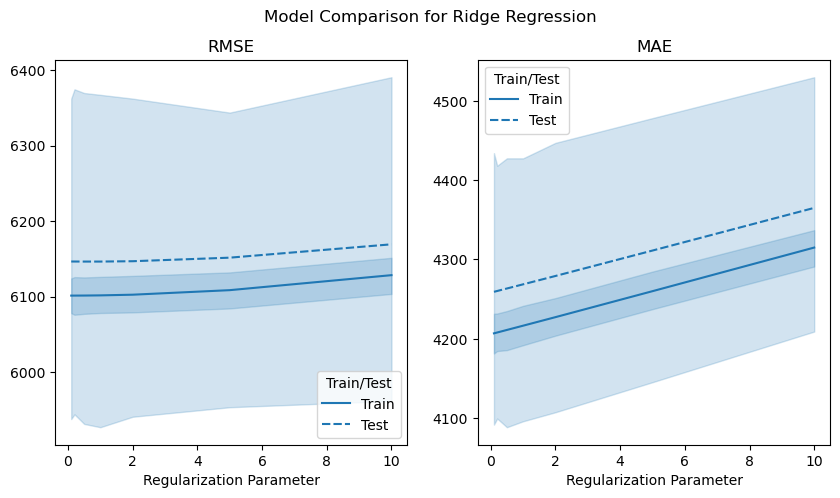

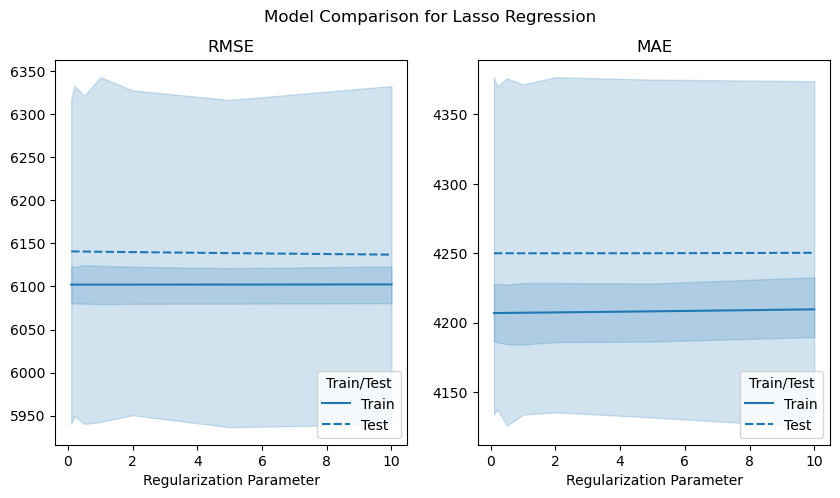

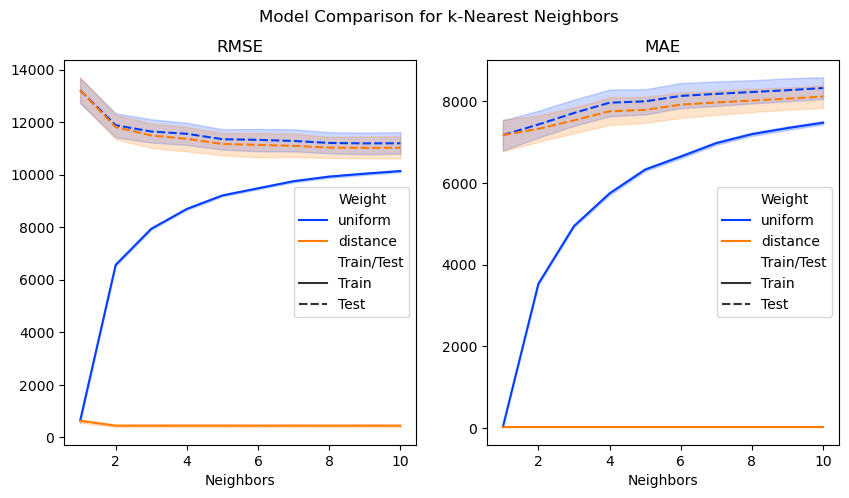

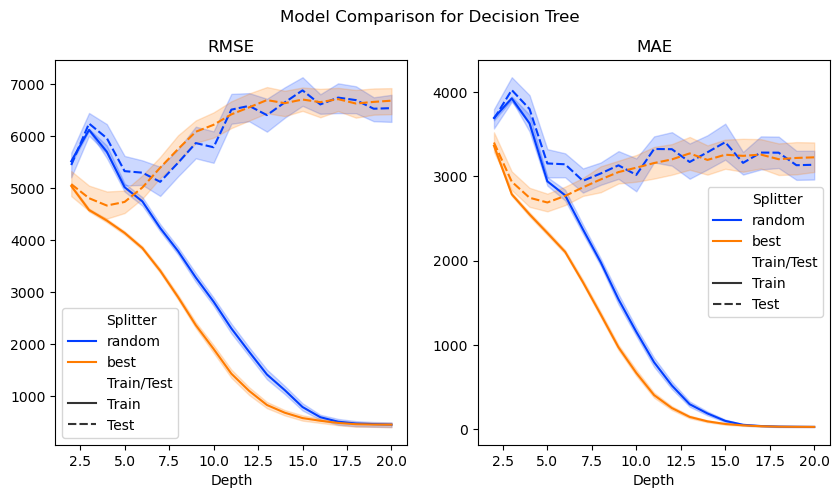

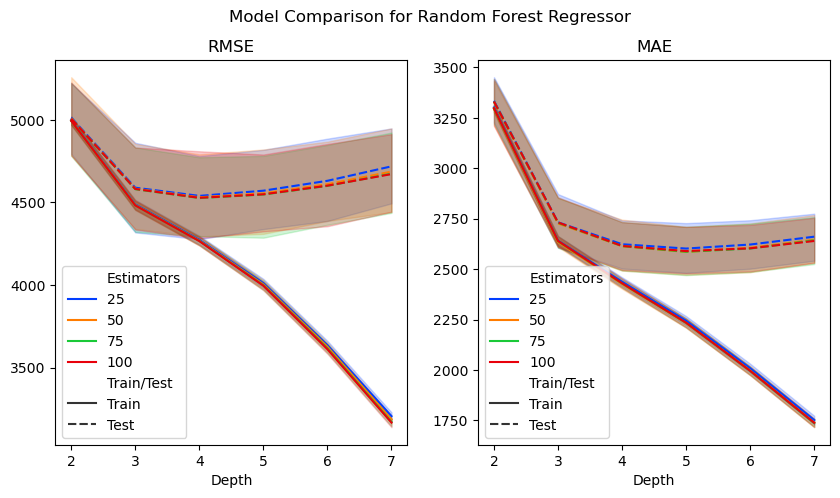

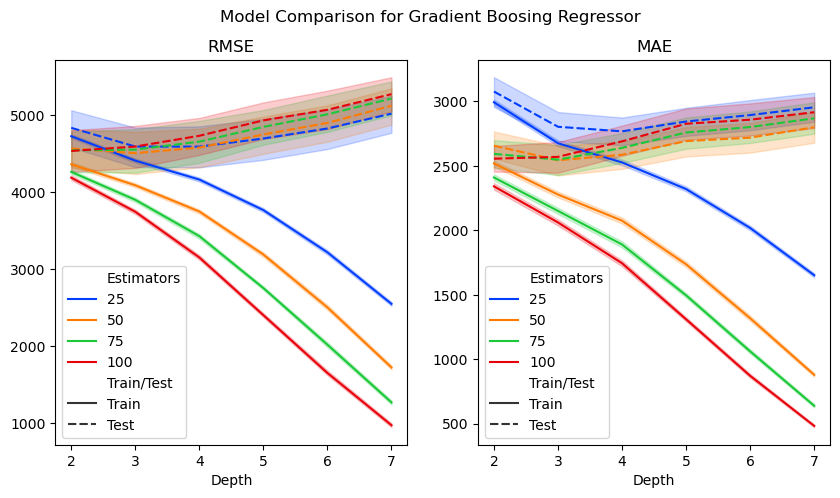

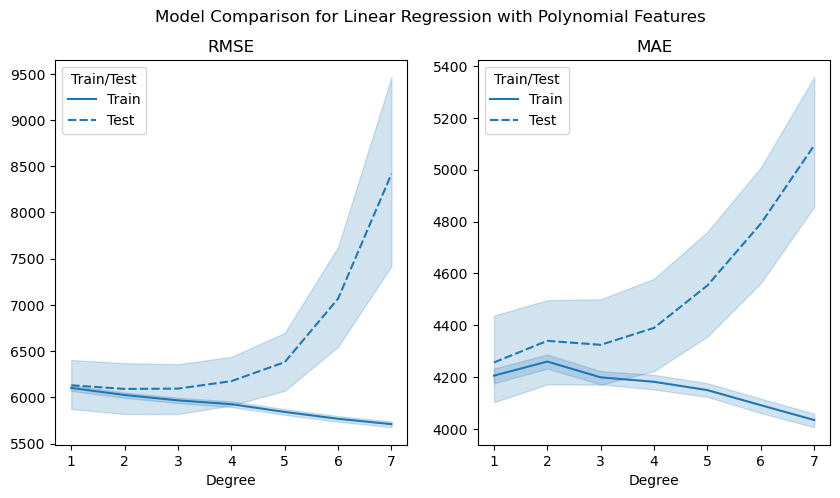

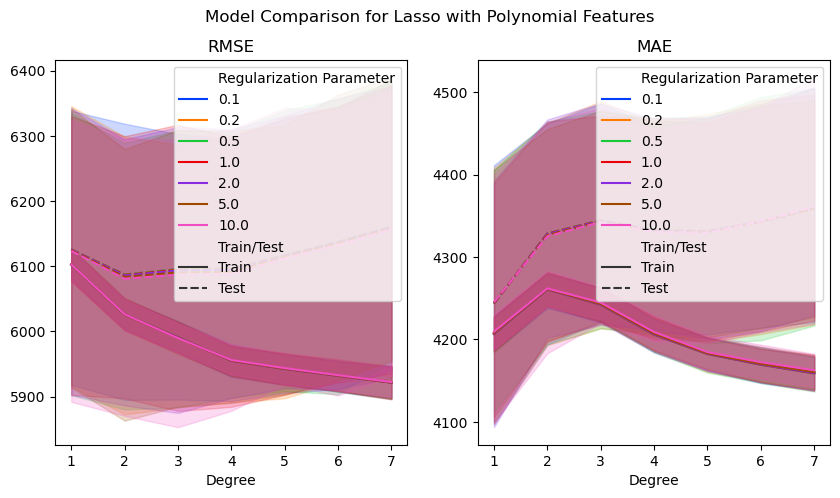

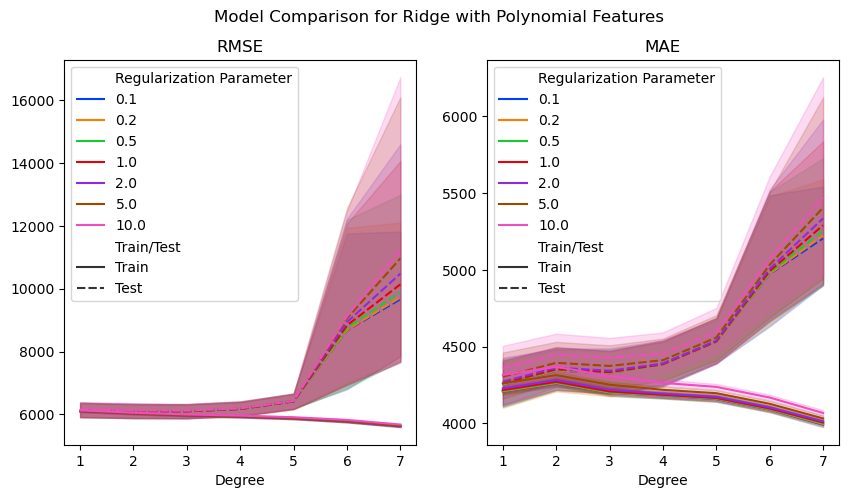

In [29]:
metric_names = list(metric_dict.keys())
style = 'Train/Test'
subplotSize = (5,5)
for model in model_names:
    if model=='lin_reg':
        continue
    reform_df = reformatted_grid[model]
    title = 'Model Comparison for '+titles[model]
    complexity = complexity_params[model]
    hue = hues[model]
    plotBV(df = reform_df,
           metrics=metric_names,
           title = title,
           hues = hue,
           complexity_param = complexity,
           subplotSize = subplotSize,
           style = style
           )